In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [9]:

# Direct path (relative to where you're running the notebook)
data_path = os.path.join("..", "data", "all_events_tidy.csv")

# Read the CSV
df = pd.read_csv(data_path, parse_dates=["release_date", "reference_month"])

/var/folders/7g/_dnl91sd56b9wcw7ngkxlfdc0000gn/T/ipykernel_12650/2211167452.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(data_path, parse_dates=["release_date", "reference_month"])


In [18]:
# Normalize release_date to tz-naive datetime
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
try:
    # drop timezone if present
    df["release_date"] = df["release_date"].dt.tz_localize(None)
except (TypeError, AttributeError):
    pass  # already tz-naive


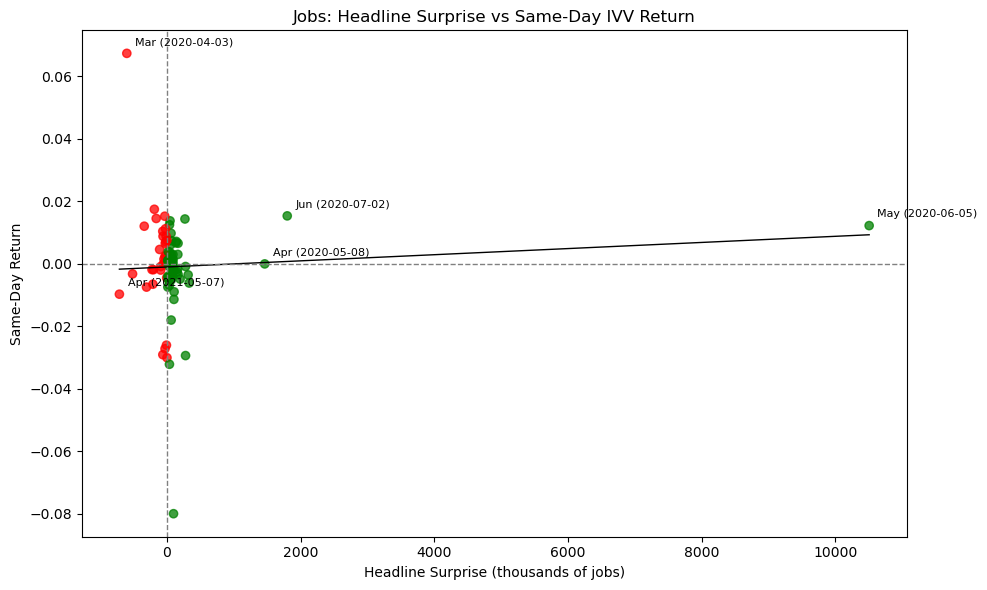

In [14]:
# --- Helper to parse surprises like '+187K', '-45K' ---
def parse_magnitude(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    if s == "" or s.upper() == "N/A":
        return np.nan
    sign = -1.0 if s.startswith("-") else 1.0
    s_clean = s.replace("+", "").replace("-", "")
    try:
        if s_clean.endswith("pp"):   # percentage points
            return sign * float(s_clean[:-2].strip())
        if s_clean.endswith("%"):    # percent
            return sign * float(s_clean[:-1].strip())
        if s_clean.endswith(("K","k")):   # thousands
            return sign * float(s_clean[:-1].strip())
        if s_clean.endswith(("M","m")):   # millions → thousands
            return sign * float(s_clean[:-1].strip()) * 1000.0
        return sign * float(s_clean)
    except:
        return np.nan

# --- Filter to jobs reports ---
jobs = df[df["event_type"] == "jobs"].copy()

# Parse the surprise (headline) into numeric form
jobs["surprise_num"] = jobs["surprise"].apply(parse_magnitude)  # thousands of jobs

# Convert returns to numeric
jobs["same_day_return"] = pd.to_numeric(
    jobs.get("same_day_return", jobs.get("ivv_same_day_return")),
    errors="coerce"
)

# Drop rows with missing data
plot_df = jobs.dropna(subset=["surprise_num", "same_day_return"]).copy()

# Classify surprises for coloring
plot_df["surprise_sign"] = np.where(plot_df["surprise_num"] > 0, "Positive", "Negative")

# --- Plot: Headline Surprise vs Same-Day Return ---
x = plot_df["surprise_num"].values
y = plot_df["same_day_return"].values

plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.75, c=np.where(plot_df["surprise_sign"] == "Positive", "green", "red"))

# Trendline
m, b = np.polyfit(x, y, 1)
xs = np.linspace(np.min(x), np.max(x), 200)
plt.plot(xs, m*xs + b, color="black", lw=1)

# Annotate top 5 absolute surprises
top5_idx = np.argsort(np.abs(x))[-5:]
for idx in top5_idx:
    label = f"{plot_df.iloc[idx]['reference_month']} ({plot_df.iloc[idx]['release_date'].date()})"
    plt.annotate(label, (x[idx], y[idx]), textcoords="offset points", xytext=(6,6), fontsize=8)

plt.axhline(0, linestyle="--", linewidth=1, color="gray")
plt.axvline(0, linestyle="--", linewidth=1, color="gray")
plt.title("Jobs: Headline Surprise vs Same-Day IVV Return")
plt.xlabel("Headline Surprise (thousands of jobs)")
plt.ylabel("Same-Day Return")
plt.tight_layout()
plt.show()


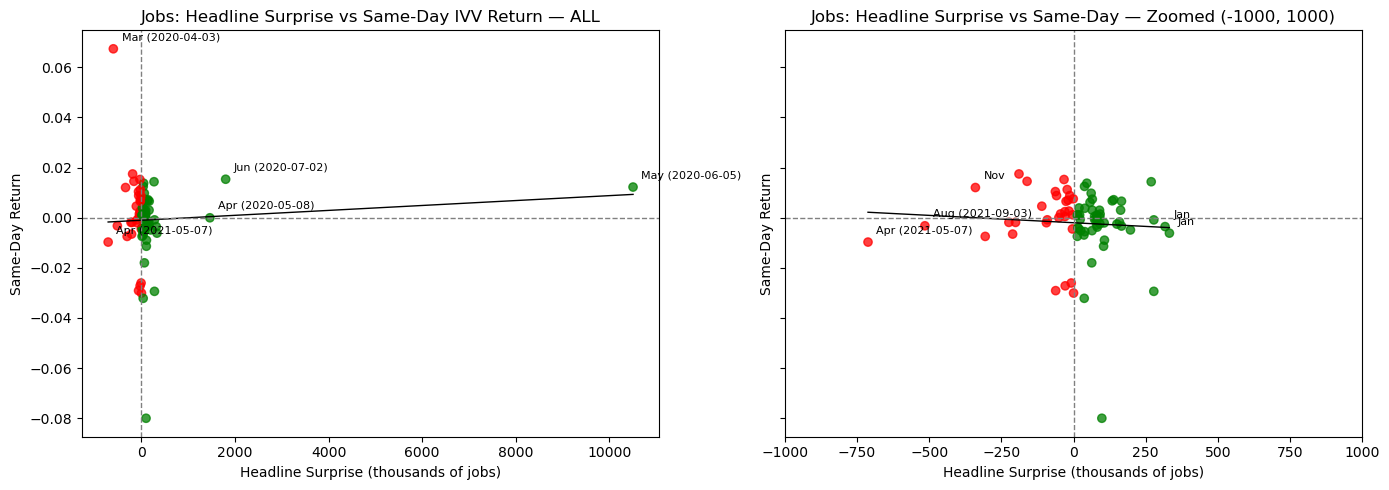

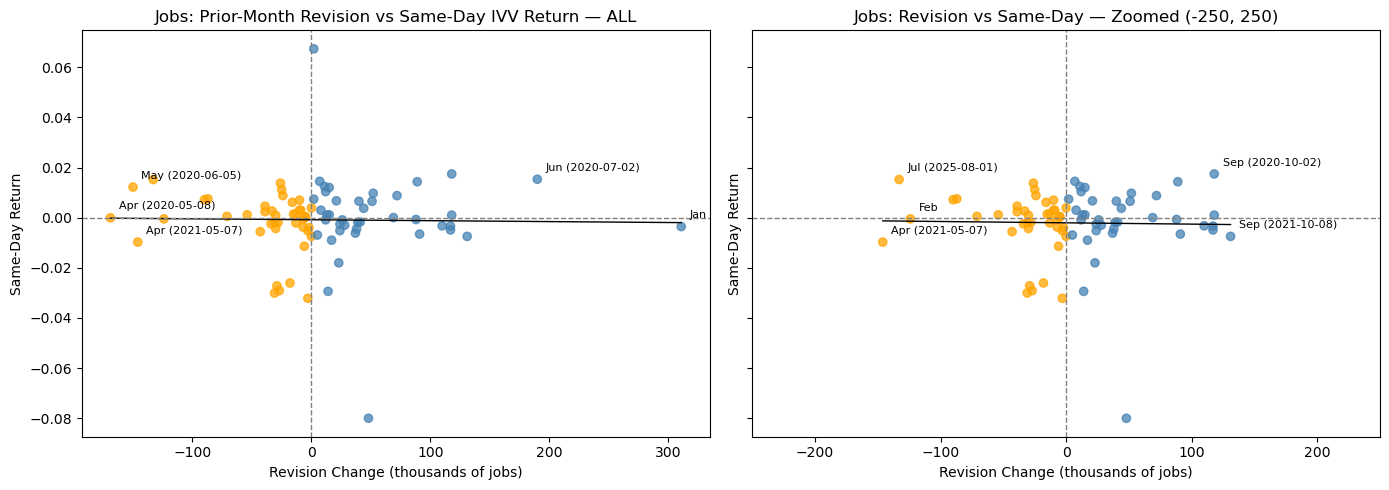

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =======================
# Config knobs
# =======================
EXCLUDE_COVID = True                   # drop 2020-03 to 2020-07 for the "zoomed" charts
HEADLINE_XLIM = (-1000, 1000)          # headline surprise zoom (thousands of jobs)
REVISION_XLIM = (-250, 250)            # revision change zoom (thousands of jobs)
LABEL_TOP_N = 5                        # annotate N biggest absolute points
# =======================

def parse_mag(x):
    """Parse strings like '-33K', '2.7%', '+0.1pp', '1.2M' -> float.
       Jobs units become 'thousands' for both headline surprise & revisions."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s == "" or s.upper() == "N/A":
        return np.nan
    sign = -1.0 if s.startswith("-") else 1.0
    s = s.replace("+","").replace("-","")
    try:
        if s.endswith("pp"):
            return sign * float(s[:-2].strip())
        if s.endswith("%"):
            return sign * float(s[:-1].strip())
        if s.endswith(("K","k")):
            return sign * float(s[:-1].strip())
        if s.endswith(("M","m")):
            return sign * float(s[:-1].strip()) * 1000.0
        return sign * float(s)
    except:
        return np.nan

def scatter_with_trend(ax, x, y, color, title, xlabel, ylabel, xlim=None, annotate_df=None, ann_label_cols=("reference_month","release_date")):
    ax.scatter(x, y, alpha=0.75, c=color)
    # trend line (ignore NaNs)
    mask = (~np.isnan(x)) & (~np.isnan(y))
    if mask.sum() >= 2:
        m, b = np.polyfit(x[mask], y[mask], 1)
        xs = np.linspace(np.nanmin(x[mask]), np.nanmax(x[mask]), 200)
        ax.plot(xs, m*xs + b, color="black", lw=1)
    ax.axhline(0, ls="--", lw=1, color="gray")
    ax.axvline(0, ls="--", lw=1, color="gray")
    if xlim:
        ax.set_xlim(*xlim)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # annotate a few extreme points
    if annotate_df is not None and len(annotate_df) > 0:
        for _, r in annotate_df.iterrows():
            label = str(r.get(ann_label_cols[0], ""))
            rd = r.get(ann_label_cols[1], None)
            if pd.notna(rd):
                try:
                    label += f" ({pd.to_datetime(rd).date()})"
                except:
                    pass
            ax.annotate(label, (r["x"], r["y"]), textcoords="offset points", xytext=(6,6), fontsize=8)

# ---- Load tidy dataset & prep jobs-only ----

jobs = df[df["event_type"] == "jobs"].copy()

# Parse numerics
jobs["surprise_num"] = jobs["surprise"].apply(parse_mag)                # thousands
jobs["revision_change_num"] = jobs["revision_change"].apply(parse_mag)  # thousands
jobs["same_day_return"] = pd.to_numeric(jobs.get("same_day_return", jobs.get("ivv_same_day_return")), errors="coerce")
jobs["next_day_return"] = pd.to_numeric(jobs.get("next_day_return", jobs.get("ivv_next_day_return")), errors="coerce")

# Base filtered data
base = jobs.dropna(subset=["same_day_return"])

# ---- A) Headline surprise vs same-day return ----
A_all = base.dropna(subset=["surprise_num"]).copy()
covid_start = pd.Timestamp("2020-03-01")
covid_end   = pd.Timestamp("2020-07-31")

A_zoom = A_all.copy()
if EXCLUDE_COVID:
    A_zoom = A_zoom[~A_zoom["release_date"].between(covid_start, covid_end)]
A_zoom = A_zoom[(A_zoom["surprise_num"] >= HEADLINE_XLIM[0]) & (A_zoom["surprise_num"] <= HEADLINE_XLIM[1])]

# colors by sign
A_all["color"] = np.where(A_all["surprise_num"] > 0, "green", "red")
A_zoom["color"] = np.where(A_zoom["surprise_num"] > 0, "green", "red")

# annotate top-N extremes by absolute surprise
A_all_top = A_all.reindex(np.abs(A_all["surprise_num"]).sort_values(ascending=False).index[:LABEL_TOP_N]).assign(x=lambda d: d["surprise_num"], y=lambda d: d["same_day_return"])
A_zoom_top = A_zoom.reindex(np.abs(A_zoom["surprise_num"]).sort_values(ascending=False).index[:LABEL_TOP_N]).assign(x=lambda d: d["surprise_num"], y=lambda d: d["same_day_return"])

fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)
scatter_with_trend(
    axes[0],
    A_all["surprise_num"].values,
    A_all["same_day_return"].values,
    A_all["color"].values,
    "Jobs: Headline Surprise vs Same-Day IVV Return — ALL",
    "Headline Surprise (thousands of jobs)",
    "Same-Day Return",
    xlim=None,
    annotate_df=A_all_top
)
scatter_with_trend(
    axes[1],
    A_zoom["surprise_num"].values,
    A_zoom["same_day_return"].values,
    A_zoom["color"].values,
    f"Jobs: Headline Surprise vs Same-Day — Zoomed {HEADLINE_XLIM}",
    "Headline Surprise (thousands of jobs)",
    "Same-Day Return",
    xlim=HEADLINE_XLIM,
    annotate_df=A_zoom_top
)
plt.tight_layout()
plt.show()

# ---- B) Revision change vs same-day return ----
B_all = base.dropna(subset=["revision_change_num"]).copy()
B_zoom = B_all.copy()
if EXCLUDE_COVID:
    B_zoom = B_zoom[~B_zoom["release_date"].between("2020-03-01", "2020-07-31")]
B_zoom = B_zoom[(B_zoom["revision_change_num"] >= REVISION_XLIM[0]) & (B_zoom["revision_change_num"] <= REVISION_XLIM[1])]

# colors by revision sign
B_all["color"] = np.where(B_all["revision_change_num"] > 0, "steelblue", "orange")
B_zoom["color"] = np.where(B_zoom["revision_change_num"] > 0, "steelblue", "orange")

B_all_top = B_all.reindex(np.abs(B_all["revision_change_num"]).sort_values(ascending=False).index[:LABEL_TOP_N]).assign(x=lambda d: d["revision_change_num"], y=lambda d: d["same_day_return"])
B_zoom_top = B_zoom.reindex(np.abs(B_zoom["revision_change_num"]).sort_values(ascending=False).index[:LABEL_TOP_N]).assign(x=lambda d: d["revision_change_num"], y=lambda d: d["same_day_return"])

fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)
scatter_with_trend(
    axes[0],
    B_all["revision_change_num"].values,
    B_all["same_day_return"].values,
    B_all["color"].values,
    "Jobs: Prior-Month Revision vs Same-Day IVV Return — ALL",
    "Revision Change (thousands of jobs)",
    "Same-Day Return",
    xlim=None,
    annotate_df=B_all_top
)
scatter_with_trend(
    axes[1],
    B_zoom["revision_change_num"].values,
    B_zoom["same_day_return"].values,
    B_zoom["color"].values,
    f"Jobs: Revision vs Same-Day — Zoomed {REVISION_XLIM}",
    "Revision Change (thousands of jobs)",
    "Same-Day Return",
    xlim=REVISION_XLIM,
    annotate_df=B_zoom_top
)
plt.tight_layout()
plt.show()


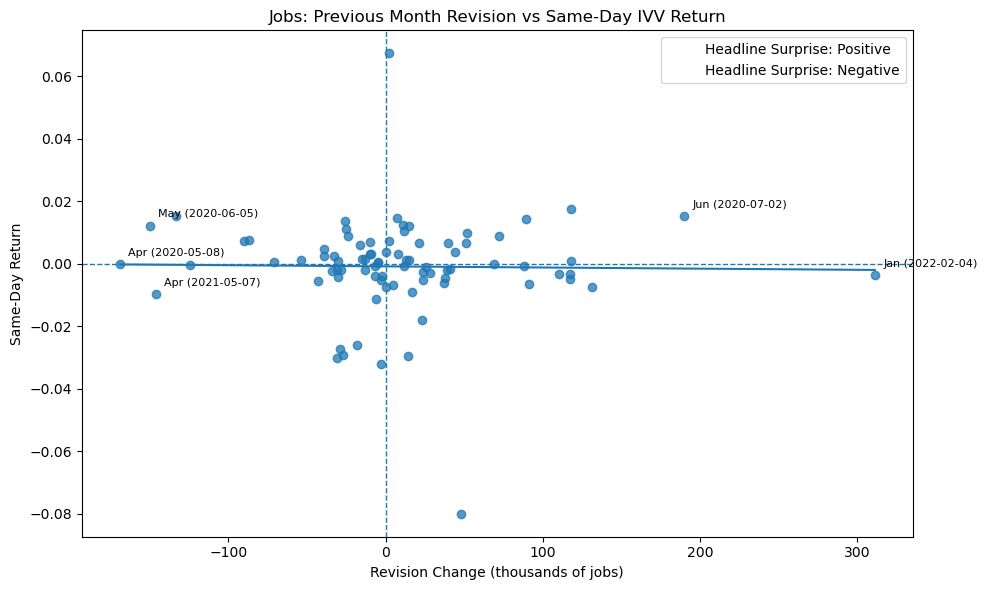

In [13]:
# --- 2) Helpers to parse strings like '-133K', '2.7%', '+0.1pp' into numbers ---
def parse_magnitude(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    if s == "" or s.upper() == "N/A":
        return np.nan
    sign = -1.0 if s.startswith("-") else 1.0
    s_clean = s.replace("+", "").replace("-", "")
    try:
        if s_clean.endswith("pp"):   # percentage points
            return sign * float(s_clean[:-2].strip())
        if s_clean.endswith("%"):    # percent
            return sign * float(s_clean[:-1].strip())
        if s_clean.endswith(("K","k")):   # thousands
            return sign * float(s_clean[:-1].strip())
        if s_clean.endswith(("M","m")):   # millions -> thousands
            return sign * float(s_clean[:-1].strip()) * 1000.0
        return sign * float(s_clean)
    except:
        return np.nan

# --- 3) Filter to jobs and create numeric columns ---
jobs = df[df["event_type"] == "jobs"].copy()

# Parse revision change (K) and surprise (K) to numeric
jobs["revision_change_num"] = jobs["revision_change"].apply(parse_magnitude)  # in thousands
jobs["surprise_num"] = jobs["surprise"].apply(parse_magnitude)                # in thousands (for jobs)

# Returns numeric (in case they are strings)
jobs["same_day_return"] = pd.to_numeric(jobs.get("same_day_return", jobs.get("ivv_same_day_return")), errors="coerce")
jobs["next_day_return"] = pd.to_numeric(jobs.get("next_day_return", jobs.get("ivv_next_day_return")), errors="coerce")

# Drop rows we can't plot
plot_df = jobs.dropna(subset=["revision_change_num", "same_day_return"]).copy()

# Bucket surprise into pos/neg for coloring
plot_df["surprise_sign"] = np.where(plot_df["surprise_num"] > 0, "Positive", "Negative")

# --- 4) Matplotlib scatter with trendline (same-day) ---
x = plot_df["revision_change_num"].values  # already in thousands
y = plot_df["same_day_return"].values

plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.75)

# Trendline
if len(plot_df) >= 2:
    m, b = np.polyfit(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], 1)
    xs = np.linspace(np.nanmin(x), np.nanmax(x), 200)
    plt.plot(xs, m*xs + b)

# Annotate top 5 absolute revisions
top5_idx = np.argsort(np.abs(x))[-5:]
for idx in top5_idx:
    try:
        label = f"{plot_df.iloc[idx]['reference_month']} ({plot_df.iloc[idx]['release_date'].date()})"
    except Exception:
        label = str(plot_df.iloc[idx].get("reference_month", ""))
    plt.annotate(label, (x[idx], y[idx]), textcoords="offset points", xytext=(6,6), fontsize=8)

plt.axhline(0, linestyle="--", linewidth=1)
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Jobs: Previous Month Revision vs Same-Day IVV Return")
plt.xlabel("Revision Change (thousands of jobs)")
plt.ylabel("Same-Day Return")

# Add a tiny legend for sign buckets
pos_mask = plot_df["surprise_sign"] == "Positive"
neg_mask = plot_df["surprise_sign"] == "Negative"
plt.scatter(x[pos_mask], y[pos_mask], alpha=0.0, label="Headline Surprise: Positive")  # invisible handles
plt.scatter(x[neg_mask], y[neg_mask], alpha=0.0, label="Headline Surprise: Negative")
plt.legend()
plt.tight_layout()
plt.show()
